# On the shoulders of giants

TODO:
    
Implement SGD with restarts with Learning rate scheduler

In [1]:
import keras
from keras import backend as K
from keras.applications import VGG16, ResNet50

Using TensorFlow backend.


In [2]:
vgg = VGG16(weights='imagenet', 
            include_top=False, 
            input_shape=(200,200,3))

In [3]:
from keras.layers import Dense, Dropout, Flatten

model = keras.Sequential()
vgg.trainable = False
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

ResNet50 requires at least 197x197 input, so in order to make a fair comparison we'll train both with those dimensions

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

# Con batch size de 50 funcionaba mucho mejor, pero lo he tenido que bajar por memoria de la GPU
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(200,200),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(200,200),
                                                        batch_size=100,
                                                        class_mode='binary')

Found 1550 images belonging to 2 classes.
Found 393 images belonging to 2 classes.


In [5]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = model.fit_generator(train_generator,
                                 steps_per_epoch=15,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 validation_steps=2)

Epoch 1/20
15/15 [==============================] - 86s 6s/step - loss: 1.0664 - acc: 0.5267 - val_loss: 0.6599 - val_acc: 0.5450
Epoch 2/20
15/15 [==============================] - 22s 1s/step - loss: 0.7038 - acc: 0.5973 - val_loss: 0.5487 - val_acc: 0.8100
Epoch 3/20
15/15 [==============================] - 22s 1s/step - loss: 0.5721 - acc: 0.6887 - val_loss: 0.4919 - val_acc: 0.8150
Epoch 4/20
15/15 [==============================] - 20s 1s/step - loss: 0.5141 - acc: 0.7560 - val_loss: 0.4154 - val_acc: 0.8350
Epoch 5/20
15/15 [==============================] - 22s 1s/step - loss: 0.4955 - acc: 0.7680 - val_loss: 0.4046 - val_acc: 0.8500
Epoch 6/20
15/15 [==============================] - 21s 1s/step - loss: 0.4350 - acc: 0.8055 - val_loss: 0.3616 - val_acc: 0.8500
Epoch 7/20
15/15 [==============================] - 21s 1s/step - loss: 0.4358 - acc: 0.8020 - val_loss: 0.3845 - val_acc: 0.8200
Epoch 8/20
15/15 [==============================] - 19s 1s/step - loss: 0.4491 - acc: 0.79

In [6]:
model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history_pt2 = model.fit_generator(train_generator,
                                 steps_per_epoch=15,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 validation_steps=2)

model.save('vgg_frozen_convbase.h5')

Epoch 1/20
15/15 [==============================] - 23s 2s/step - loss: 0.3450 - acc: 0.8455 - val_loss: 0.2826 - val_acc: 0.8700
Epoch 2/20
15/15 [==============================] - 21s 1s/step - loss: 0.3175 - acc: 0.8459 - val_loss: 0.2654 - val_acc: 0.8750
Epoch 3/20
15/15 [==============================] - 20s 1s/step - loss: 0.3160 - acc: 0.8405 - val_loss: 0.2680 - val_acc: 0.8750
Epoch 4/20
15/15 [==============================] - 20s 1s/step - loss: 0.3292 - acc: 0.8372 - val_loss: 0.2732 - val_acc: 0.8600
Epoch 5/20
15/15 [==============================] - 22s 1s/step - loss: 0.3268 - acc: 0.8440 - val_loss: 0.2797 - val_acc: 0.8700
Epoch 6/20
15/15 [==============================] - 20s 1s/step - loss: 0.3000 - acc: 0.8654 - val_loss: 0.2763 - val_acc: 0.8750
Epoch 7/20
15/15 [==============================] - 21s 1s/step - loss: 0.3193 - acc: 0.8641 - val_loss: 0.2671 - val_acc: 0.8750
Epoch 8/20
15/15 [==============================] - 22s 1s/step - loss: 0.3228 - acc: 0.86

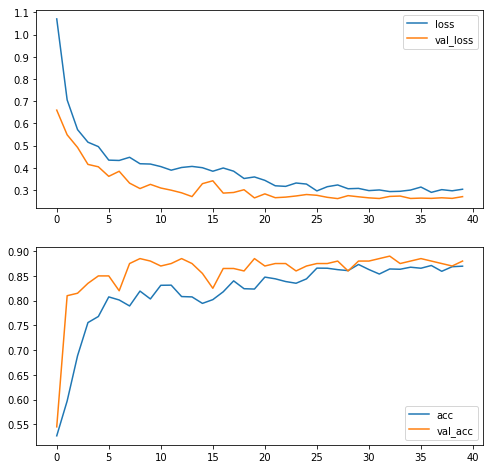

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

nb_epochs = len(history.epoch)
concatenated = history.epoch + [nb_epochs + epoch_number for epoch_number in history_pt2.epoch]

axes[0].plot(concatenated, history.history['loss'] + history_pt2.history['loss'], label='loss')
axes[0].plot(concatenated, history.history['val_loss'] + history_pt2.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(concatenated, history.history['acc'] + history_pt2.history['acc'], label='acc')
axes[1].plot(concatenated, history.history['val_acc'] + history_pt2.history['val_acc'], label='val_acc')
axes[1].legend()

### Fine Tuning

In [8]:
# The VGG16 inside my model:

model.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [9]:
for layer in model.layers[0].layers:
    if 'block5' in layer.name: 
        layer.trainable = True
    else: 
        layer.trainable = False
        
model.layers[0].trainable = True   

In [10]:
[layer.trainable for layer in model.layers[0].layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

Now we keep training the model. This time we will be updating the top few layers. We want to reduce the learning rate in order to keep them from 'flailing around'

At first the loss and accuracy get worse, but they will start improving soon enough.

In [11]:
model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history = model.fit_generator(train_generator,
                                 steps_per_epoch=25,
                                 epochs=40,
                                 validation_data=validation_generator,
                                 validation_steps=2)

model.save('vgg_unfrozen_convbase.h5')

Epoch 1/40
25/25 [==============================] - 36s 1s/step - loss: 0.6025 - acc: 0.6200 - val_loss: 0.4931 - val_acc: 0.6150
Epoch 2/40
25/25 [==============================] - 34s 1s/step - loss: 0.3727 - acc: 0.8148 - val_loss: 0.2303 - val_acc: 0.9350
Epoch 3/40
25/25 [==============================] - 34s 1s/step - loss: 0.2677 - acc: 0.8984 - val_loss: 0.3267 - val_acc: 0.8750
Epoch 4/40
25/25 [==============================] - 34s 1s/step - loss: 0.2109 - acc: 0.9200 - val_loss: 0.4454 - val_acc: 0.8400
Epoch 5/40
25/25 [==============================] - 34s 1s/step - loss: 0.2469 - acc: 0.8988 - val_loss: 0.2746 - val_acc: 0.9150
Epoch 6/40
25/25 [==============================] - 34s 1s/step - loss: 0.2215 - acc: 0.9148 - val_loss: 0.1835 - val_acc: 0.9400
Epoch 7/40
25/25 [==============================] - 33s 1s/step - loss: 0.1464 - acc: 0.9411 - val_loss: 0.2094 - val_acc: 0.9500
Epoch 8/40
25/25 [==============================] - 36s 1s/step - loss: 0.1131 - acc: 0.95

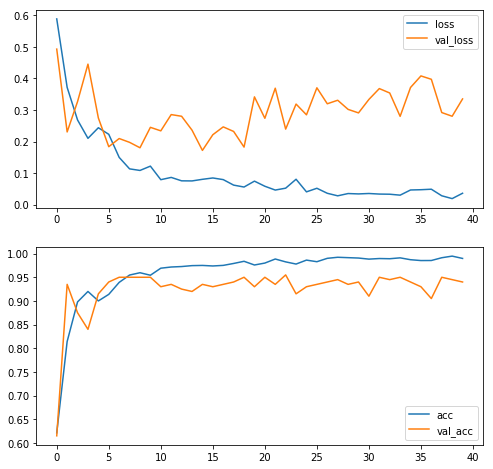

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

axes[0].plot(history.epoch, history.history['loss'], label='loss')
axes[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(history.epoch, history.history['acc'], label='acc')
axes[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
axes[1].legend()

### ResNet50

WTF?? It doesn't learn anything transferable at all!!

In [ ]:
resnet = ResNet50(weights='imagenet', 
                  include_top=False, 
                  input_shape=(200,200,3))


resnet.trainable = False

othermodel = keras.Sequential()
othermodel.add(resnet)
othermodel.add(Flatten())
othermodel.add(Dense(256, activation='relu'))
othermodel.add(Dropout(0.5))
othermodel.add(Dense(128, activation='relu'))
othermodel.add(Dropout(0.5))
othermodel.add(Dense(64, activation='relu'))
othermodel.add(Dropout(0.5))
othermodel.add(Dense(1, activation='sigmoid'))

othermodel.summary()

In [ ]:
othermodel.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = othermodel.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=50,
                                 validation_data=validation_generator,
                                 validation_steps=2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)


axes[0].plot(history.epoch, history.history['loss'], label='loss')
axes[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(history.epoch, history.history['acc'], label='acc')
axes[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
axes[1].legend()